<a href="https://colab.research.google.com/github/bbhavii/Project-Work/blob/main/SentimentAnalysisAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the necessary packages.

In [ ]:
!pip install transformers
!pip install tensorflow_text
!pip install sentence_transformers
import torch
import re
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as tf_text
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['product','quality','good','nan'])
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from nltk.stem import SnowballStemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 46.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=6b7e34d46da7ddc21823418c4e4d4609c7f80b3ffc316777a216f7a3d808e81b
  St

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

# Reading the dataset, creating the data frame with combined data and labels for use.

In [ ]:
df = pd.read_csv('Dataset-SA.csv')
data = []
sparse_coding = []
one_hot_coding = []

for row in df.itertuples():
  #if row[3]
  full = str(row[4])+' '+str(row[5])
  full = full.translate(str.maketrans('','',string.punctuation))
  full = full.lower()
  if full.find('nan'):
    full = full.replace('nan',' ')
  if full.find('not specified'):
    full = full.replace('not specified',' ')
  data.append(full)
  #full_str = full_str.join(full)
  if row[6]=='positive':
    sparse_coding.append(0)
    one_hot_coding.append([1,0,0])
  elif row[6]=='negative':
    sparse_coding.append(1)
    one_hot_coding.append([0,1,0])  
  else:
    sparse_coding.append(2)
    one_hot_coding.append([0,0,1])  

df['data'] = data
df['sparse_sent'] = sparse_coding
df['one_hot_sent'] = one_hot_coding

df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment,data,sparse_sent,one_hot_sent
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive,super great cooler excellent air flow and for ...,0,"[1, 0, 0]"
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive,awesome best budget 2 fit cooler nice cooling,0,"[1, 0, 0]"
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive,fair the quality is good but the power of air ...,0,"[1, 0, 0]"
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative,useless product very bad product its a only a fan,1,"[0, 1, 0]"
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral,fair ok ok product,2,"[0, 0, 1]"


# Preparing some statistics for the data.

In [ ]:
print(len(df['product_name'].value_counts()))

In [ ]:
print(df['Rate'].value_counts())

In [ ]:
df['Sentiment'].value_counts().plot(kind = 'bar', title='Sentiment Label Statistics')

# Dividing the data into different data frames so as to only use 70% for training and the rest for testing purposes.

Positive count: : (166581, 9)
Negative count: : (28232, 9)
Neutral count: : (10239, 9)


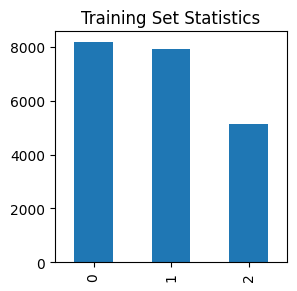

In [ ]:
df_positive = df[df['Sentiment']=='positive']
print('Positive count: :',df_positive.shape)
df_positive = df_positive.sample(frac=1)
df_negative = df[df['Sentiment']=='negative']
print('Negative count: :', df_negative.shape)
df_negative = df_negative.sample(frac=1)
df_neutral = df[df['Sentiment']=='neutral']
print('Neutral count: :',df_neutral.shape)
df_neutral = df_neutral.sample(frac=1)

limitpos = int(0.07*0.7*len(df_positive))
limitneg = int(0.4*0.7*len(df_negative))
limitneut = int(0.5*len(df_neutral))
valimitpos = limitpos + int(0.06*0.7*len(df_positive)/2)
valimitneg = limitneg + int(0.3*0.7*len(df_negative)/2)
valimitneut = limitneut + int(0.6*len(df_neutral)/2)

df_train = pd.concat([df_positive[:limitpos], df_negative[:limitneg], df_neutral[:limitneut]])
df_train = df_train.sample(frac=1)
df_valid = pd.concat([df_positive[limitpos:valimitpos],df_negative[limitneg:valimitneg],df_neutral[limitneut:valimitneut]])
df_valid = df_valid.sample(frac=1)
df_test = pd.concat([df_positive[int(0.98*len(df_positive)):len(df_positive)],
                    df_negative[int(0.9*len(df_negative)):len(df_negative)],
                    df_neutral[int(0.7*len(df_neutral)):len(df_neutral)]])
df_test = df_test.sample(frac=1)

df_train['sparse_sent'].value_counts().plot(kind = 'bar',figsize=(3, 3), title='Training Set Statistics');

In [ ]:
df_valid['sparse_sent'].value_counts().plot(kind = 'bar',figsize=(3, 3), title='Validation Set Statistics');

In [ ]:
df_test['sparse_sent'].value_counts().plot(kind = 'bar',figsize=(3, 3), title='Test Set Statistics');

# Calculating class weights to make up for the class imbalance.

In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(df_train['sparse_sent']),
                                        y = df_train['sparse_sent']                                                    
                                    )
class_weights = dict(zip([0,1,2], class_weights))
print('Class Weights for training set :',class_weights)

Class Weights for training set : {0: 0.8651882708486482, 1: 0.8934294871794872, 2: 1.379501204662369}


# Making the model.

The model begins with a BERT preprocessing layer and an embedding layer. Following this we have CNN layer followed by MaxPool, and Dropout.
Once the features have been extracted we employ dense layers with an activation of 'relu', with a final dense layer with 3 nodes since we have 3 classes. 

The Adam optimiser is used with a learning rate of 0.001.

In [ ]:
X_train = tf.keras.layers.Input(shape=(), dtype=tf.string, name="X_data")
X_train_pp = bert_preprocess(X_train)
X_train_embedded = bert_encoder(X_train_pp)

In [ ]:
l = tf.keras.layers.Conv1D(filters=16,kernel_size=2,activation='relu')(X_train_embedded['sequence_output'])
l = tf.keras.layers.MaxPool1D(pool_size=2)(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Conv1D(filters=16,kernel_size=2,activation='relu')(l)
l = tf.keras.layers.MaxPool1D(pool_size=2)(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Dense(32, activation='relu')(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Dense(16, activation='relu')(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Flatten()(l)
l = tf.keras.layers.Dense(3, activation='softmax')(l)

model = tf.keras.Model(inputs=[X_train], outputs = [l])

model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

NameError: ignored

In [ ]:
history = model.fit(df_train['data'],
                    df_train['sparse_sent'],
                    epochs = 40,
                    batch_size = 32,
                    verbose = 1,
                    class_weight = class_weights,
                    validation_data = (df_valid['data'],df_valid['sparse_sent']))

Epoch 1/20
663/663 [==============================] - 368s 550ms/step - loss: 0.5728 - accuracy: 0.7749 - val_loss: 0.4668 - val_accuracy: 0.8057
Epoch 2/20
663/663 [==============================] - 365s 551ms/step - loss: 0.4824 - accuracy: 0.8185 - val_loss: 0.4559 - val_accuracy: 0.8068
Epoch 3/20
663/663 [==============================] - 320s 483ms/step - loss: 0.4547 - accuracy: 0.8281 - val_loss: 0.4455 - val_accuracy: 0.8115
Epoch 4/20
663/663 [==============================] - 366s 552ms/step - loss: 0.4407 - accuracy: 0.8333 - val_loss: 0.4401 - val_accuracy: 0.8103
Epoch 5/20
663/663 [==============================] - 364s 550ms/step - loss: 0.4267 - accuracy: 0.8365 - val_loss: 0.4302 - val_accuracy: 0.8195
Epoch 6/20
345/663 [==============>...............] - ETA: 1:46 - loss: 0.4208 - accuracy: 0.8408

In [ ]:
model.save('https://drive.google.com/drive/my-drive')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylim(0.0,1.0)
plt.figure(figsize=(6,4))
plt.yticks(np.arange(0.0,1.0,0.05))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict((df_test['data']), verbose=1)

y_classes = predictions.argmax(axis=-1)

metrics = tf.keras.metrics.Accuracy()
metrics.update_state(y_classes, df_test['sparse_sent'])
print('Test Accuracy: ', metrics.result().numpy())

print(tf.math.confusion_matrix(
    df_test['sparse_sent'],
    y_classes,
    num_classes=3))

plt.figure(figsize=(6,4))
sns.heatmap(tf.math.confusion_matrix(
    df_test['sparse_sent'],
    y_classes,
    num_classes=3,
    annot=True))
plt.ylabel('True Labels')
plt.xlabel('Predictions')
plt.title('Confusion Matrix for Classes')
plt.show();

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


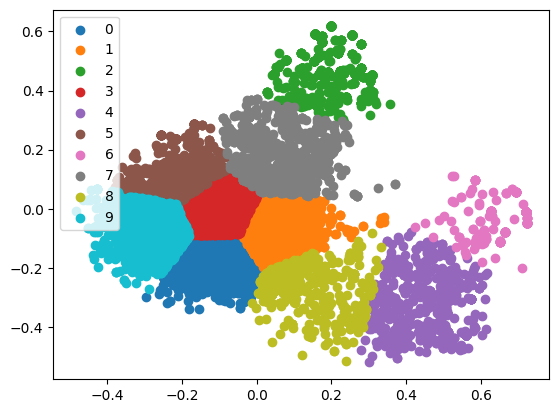

In [ ]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')

embed = model_st1.encode(list(df_neutral['data']))
em_list = []
for em in embed:
  em_list.append(em)

df_neutral['embed'] = em_list

mypca = PCA(2)
 
neutral = mypca.fit_transform(list(df_neutral['embed']))

kmeans = KMeans(n_clusters=10)

cluster = kmeans.fit_predict(neutral)

df_neutral['clusters'] = cluster

for i in np.unique(cluster):
    plt.scatter(neutral[cluster==i,0],neutral[cluster==i,1],label=i)
plt.legend()
plt.show()

In [ ]:
for num in np.arange(0,10,1):
  vectorizor = CountVectorizer().fit(df_neutral[df_neutral['clusters']==num]['data'])
  bag_of_words = vectorizor.transform(df_neutral[df_neutral['clusters']==num]['data'])
  bag_of_stop_words = vectorizor.transform(stop_words)
  stop_words.extend(['product','quality','good'])
  sum_of_words = bag_of_words.sum(axis=0) 
  words_freq = []
  for word, idx in vectorizor.vocabulary_.items():
    if(word not in stop_words):
      words_freq.append([word, sum_of_words[0, idx]])
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  print('Neutral Cluster number ',num,words_freq[:5])

Neutral Cluster number  0 [['small', 188], ['average', 179], ['size', 136], ['job', 104], ['valueformoney', 103]]
Neutral Cluster number  1 [['small', 170], ['size', 134], ['specified', 126], ['nice', 92], ['disappointed', 90]]
Neutral Cluster number  2 [['ok', 902], ['okay', 198], ['nice', 191], ['fair', 114], ['wonderful', 75]]
Neutral Cluster number  3 [['ok', 249], ['nice', 234], ['okay', 179], ['small', 108], ['job', 102]]
Neutral Cluster number  4 [['average', 131], ['bad', 80], ['size', 46], ['small', 31], ['ok', 31]]
Neutral Cluster number  5 [['ok', 581], ['job', 167], ['okay', 164], ['decent', 152], ['nice', 141]]
Neutral Cluster number  6 [['ok', 353], ['okay', 51], ['okk', 13], ['type', 8], ['nice', 6]]
Neutral Cluster number  7 [['ok', 442], ['specified', 185], ['okay', 166], ['bad', 122], ['nice', 120]]
Neutral Cluster number  8 [['average', 97], ['specified', 95], ['size', 62], ['small', 39], ['cheap', 27]]
Neutral Cluster number  9 [['decent', 235], ['nice', 173], ['pri

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


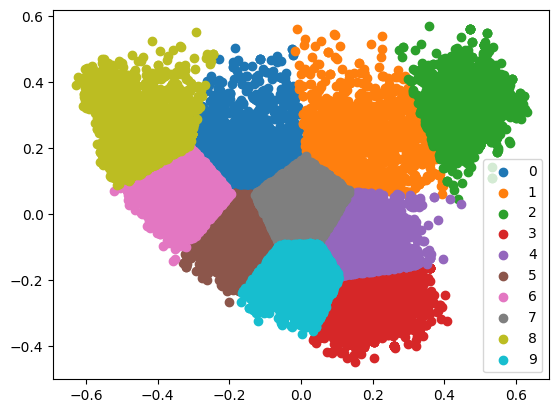

Negative Cluster number  0 [['dont', 682], ['money', 528], ['waste', 502], ['bad', 438], ['buy', 435], ['recommended', 380], ['worst', 253], ['specified', 246], ['poor', 244], ['use', 122]]
Negative Cluster number  1 [['bad', 251], ['specified', 205], ['dont', 145], ['size', 139], ['poor', 135], ['money', 124], ['buy', 123], ['waste', 114], ['cloth', 107], ['small', 105]]
Negative Cluster number  2 [['bad', 904], ['poor', 338], ['worst', 139], ['low', 127], ['size', 88], ['cloth', 76], ['fabric', 59], ['material', 59], ['bed', 59], ['waste', 49]]
Negative Cluster number  3 [['bad', 1229], ['disappointed', 699], ['poor', 464], ['utterly', 419], ['unsatisfactory', 341], ['worst', 335], ['expectations', 325], ['meet', 316], ['better', 291], ['expected', 285]]
Negative Cluster number  4 [['bad', 772], ['poor', 414], ['specified', 362], ['worthless', 264], ['moderate', 246], ['worst', 238], ['disappointed', 214], ['horrible', 185], ['unsatisfactory', 184], ['fair', 174]]
Negative Cluster nu

In [ ]:
embed = model_st1.encode(list(df_negative['data']))
em_list = []
for em in embed:
  em_list.append(em)

df_negative['embed'] = em_list

negative = mypca.fit_transform(list(df_negative['embed']))

kmeans = KMeans(n_clusters=10)

cluster = kmeans.fit_predict(negative)

df_negative['clusters'] = cluster

for i in np.unique(cluster):
    plt.scatter(negative[cluster==i,0],negative[cluster==i,1],label=i)
plt.legend()
plt.show()

for num in np.arange(0,10,1):
  vectorizor = CountVectorizer().fit(df_negative[df_negative['clusters']==num]['data'])
  bag_of_words = vectorizor.transform(df_negative[df_negative['clusters']==num]['data'])
  bag_of_stop_words = vectorizor.transform(stop_words)
  sum_of_words = bag_of_words.sum(axis=0) 
  words_freq = []
  for word, idx in vectorizor.vocabulary_.items():
    if(word not in stop_words):
      words_freq.append([word, sum_of_words[0, idx]])
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  print('Negative Cluster number ',num,words_freq[:10])

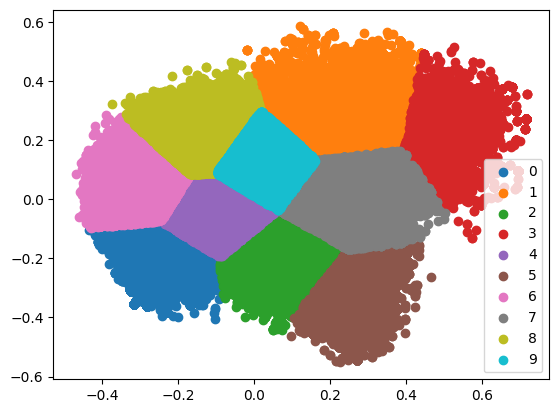

Positive Cluster number  0 [['nice', 10362], ['awesome', 3314], ['great', 2923], ['terrific', 2450], ['classy', 2287]]
Positive Cluster number  1 [['valueformoney', 983], ['specified', 731], ['super', 664], ['nice', 650], ['best', 619]]
Positive Cluster number  2 [['nice', 3207], ['awesome', 1699], ['super', 871], ['wonderful', 772], ['simply', 768]]
Positive Cluster number  3 [['nice', 2897], ['super', 654], ['awesome', 277], ['excellent', 234], ['best', 215]]
Positive Cluster number  4 [['nice', 6251], ['worth', 2673], ['awesome', 2619], ['purchase', 2517], ['terrific', 2027]]
Positive Cluster number  5 [['nice', 7526], ['awesome', 3951], ['wonderful', 2844], ['super', 2280], ['excellent', 2267]]
Positive Cluster number  6 [['nice', 5084], ['worth', 3645], ['purchase', 3113], ['money', 2946], ['best', 2634]]
Positive Cluster number  7 [['nice', 3477], ['specified', 2434], ['super', 1580], ['choice', 1043], ['wow', 791]]
Positive Cluster number  8 [['best', 6295], ['buy', 4147], ['wor

In [ ]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
embed = model_st1.encode(list(df_positive['data']))
em_list = []
for em in embed:
  em_list.append(em)

df_positive['embed'] = em_list

mypca = PCA(2)
 
positive = mypca.fit_transform(list(df_positive['embed']))

kmeans = KMeans(n_clusters=10, n_init=10)

cluster = kmeans.fit_predict(positive)

df_positive['clusters'] = cluster

for i in np.unique(cluster):
    plt.scatter(positive[cluster==i,0],positive[cluster==i,1],label=i)
plt.legend()
plt.show()

for num in np.arange(0,10,1):
  vectorizor = CountVectorizer().fit(df_positive[df_positive['clusters']==num]['data'])
  bag_of_words = vectorizor.transform(df_positive[df_positive['clusters']==num]['data'])
  bag_of_stop_words = vectorizor.transform(stop_words)
  sum_of_words = bag_of_words.sum(axis=0) 
  words_freq = []
  for word, idx in vectorizor.vocabulary_.items():
    if(word not in stop_words):
      words_freq.append([word, sum_of_words[0, idx]])
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  print('Positive Cluster number ',num,words_freq[:5])

In [ ]:
vectorizor = CountVectorizer().fit(df_positive['data'])
bag_of_words = vectorizor.transform(df_positive['data'])
bag_of_stop_words = vectorizor.transform(stop_words)
sum_of_words = bag_of_words.sum(axis=0) 
words_freq = []
for word, idx in vectorizor.vocabulary_.items():
  if(word not in stop_words):
    words_freq.append([word, sum_of_words[0, idx]])
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print('Positive words: ', words_freq[:10])

Positive words:  [['nice', 47903], ['awesome', 18691], ['best', 16290], ['super', 13367], ['purchase', 12113], ['worth', 12084], ['excellent', 11306], ['terrific', 10795], ['buy', 10013], ['great', 9829]]


In [ ]:
vectorizor = CountVectorizer().fit(df_negative['data'])
bag_of_words = vectorizor.transform(df_negative['data'])
stop_words.extend(['specified'])
bag_of_stop_words = vectorizor.transform(stop_words)
sum_of_words = bag_of_words.sum(axis=0) 
words_freq = []
for word, idx in vectorizor.vocabulary_.items():
  if(word not in stop_words):
    words_freq.append([word, sum_of_words[0, idx]])
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print('Negative words: ', words_freq[:10])

Negative words:  [['bad', 7236], ['money', 4562], ['waste', 4317], ['dont', 4117], ['poor', 3711], ['worst', 3612], ['buy', 2850], ['working', 2242], ['disappointed', 2200], ['experience', 1589]]


In [ ]:
vectorizor = CountVectorizer().fit(df_neutral['data'])
bag_of_words = vectorizor.transform(df_neutral['data'])
stop_words.extend(['specified'])
bag_of_stop_words = vectorizor.transform(stop_words)
sum_of_words = bag_of_words.sum(axis=0) 
words_freq = []
for word, idx in vectorizor.vocabulary_.items():
  if(word not in stop_words):
    words_freq.append([word, sum_of_words[0, idx]])
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print('Neutral words: ', words_freq[:10])

Neutral words:  [['ok', 2799], ['nice', 1055], ['okay', 892], ['average', 702], ['small', 613], ['bad', 543], ['decent', 524], ['job', 516], ['size', 499], ['fair', 448]]


In [ ]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
embed = model_st1.encode(list(df['data']))
em_list = []
for em in embed:
  em_list.append(em)

df['embed'] = em_list

mypca = PCA(2)
 
positive = mypca.fit_transform(list(df['embed']))

kmeans = KMeans(n_clusters=25, n_init=25)

cluster = kmeans.fit_predict(positive)

df['clusters'] = cluster

for i in np.unique(cluster):
    plt.scatter(positive[cluster==i,0],positive[cluster==i,1],label=i)
plt.legend()
plt.show()

for num in np.unique(cluster):
  vectorizor = CountVectorizer().fit(df[df['clusters']==num]['data'])
  bag_of_words = vectorizor.transform(df[df['clusters']==num]['data'])
  bag_of_stop_words = vectorizor.transform(stop_words)
  #stop_words.extend(['product','quality','good'])
  sum_of_words = bag_of_words.sum(axis=0) 
  words_freq = []
  for word, idx in vectorizor.vocabulary_.items():
    if(word not in stop_words):
      words_freq.append([word, sum_of_words[0, idx]])
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  print('Cluster number ',num,words_freq[:5])